In [5]:
'''
Try to utilize FPN on GAC network 
output anchors_gac_fpn_share_weight
'''

import sys
sys.path.insert(0, "../kitti/")
from util_kitti import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D
from util_kitti import AVG_HEIGT, AVG_WIDTH, AVG_LENTH
from util_kitti import ANCHOR_Y_3D_MEAN, ANCHOR_Y_3D_STD, KITTI_Object, draw_2Dbox
from util_kitti import draw_corner_2D, draw_birdeyes, set_bev_background, init_img_plt, load_tf_image

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2
import pprint

ANCHOR_NAME = 'anchors_gac_fpn_share_weight' # anchors_fpn_full_feature 'anchors_gac_fpn_share_weight'

INPUT_SHAPE = (288, 1280)
PYRIMID_LEVEL = [3, 4, 5, 6, 7]

# SHOW_COOR = (15, 60)
# LABEL_DIR = "/home/lab530/KenYu/kitti/training/label_2/"

P2  = kitti_calib_file_parser("/home/lab530/KenYu/kitti/training/calib/000169.txt",
                              new_shape_tf = INPUT_SHAPE,
                              crop_tf = 100)

# Width calculator
cx, cy = (640, 40)
for cz in range(0, 81, 1):
    loc_3d = np.linalg.inv(P2[:, :3]) @ np.array([[cx*cz], [cy*cz], [cz]])
    loc_3d[1, 0] += AVG_HEIGT / 2.0

    str_line = f"Car NA NA NA NA NA NA NA {AVG_HEIGT} {AVG_WIDTH} {AVG_LENTH} {loc_3d[0, 0]} {loc_3d[1, 0]} {loc_3d[2, 0]} {pi/2} NA"
    a = KITTI_Object(str_line, tf_matrix = P2)
    print(f"(cz, w, h) = {(cz, a.xmax - a.xmin, a.ymax - a.ymin)}")


(cz, w, h) = (0, 432536.4504480539, 405187.6141091038)
(cz, w, h) = (1, 432536.4504480539, 405187.6141091038)
(cz, w, h) = (2, 20263.900740121062, 18982.635070242322)
(cz, w, h) = (3, 1160.4556589039842, 1087.0812372544383)
(cz, w, h) = (4, 597.3315648980374, 559.5629024152272)
(cz, w, h) = (5, 402.17274167766533, 376.7437715163396)
(cz, w, h) = (6, 303.1336111419941, 283.9667836726108)
(cz, w, h) = (7, 243.23461243898112, 227.85513725100384)
(cz, w, h) = (8, 203.1018272844169, 190.25990695888294)
(cz, w, h) = (9, 174.3369020738021, 163.31375848043095)
(cz, w, h) = (10, 152.7090149548385, 143.05338049176405)
(cz, w, h) = (11, 135.85510282554003, 127.26512394829601)
(cz, w, h) = (12, 122.35162063923462, 114.61545309728179)
(cz, w, h) = (13, 111.2898331320988, 104.25309107402262)
(cz, w, h) = (14, 102.0623911312075, 95.60909077116186)
(cz, w, h) = (15, 94.24795296376408, 88.28875151792768)
(cz, w, h) = (16, 87.54504020641104, 82.07862101061409)
(cz, w, h) = (17, 81.73224442055187, 77.119

anchor_count = 23040 at level 3
Average anchor width = 42.85692732895102
Average anchor height = 25.914409279939793
For pyrimid level_3
anchor_count = 5760 at level 4
Average anchor width = 84.31297092398573
Average anchor height = 51.101549597137
For pyrimid level_4
anchor_count = 1440 at level 5
Average anchor width = 159.6082509535098
Average anchor height = 97.47277789541114
For pyrimid level_5
anchor_count = 400 at level 6
Average anchor width = 296.78165633842144
Average anchor height = 184.81368160414019
For pyrimid level_6
anchor_count = 120 at level 7
Average anchor width = 843.590810283928
Average anchor height = 586.6460248616338
For pyrimid level_7
anchors_tensor.shape = torch.Size([30760, 16])
level_0 has 23040 anchors
level_0 has average area of 0.0
level_1 has 5760 anchors
level_1 has average area of 0.0
level_2 has 1440 anchors
level_2 has average area of 0.0
level_3 has 400 anchors
level_3 has average area of 0.0
level_4 has 120 anchors
level_4 has average area of 0.0


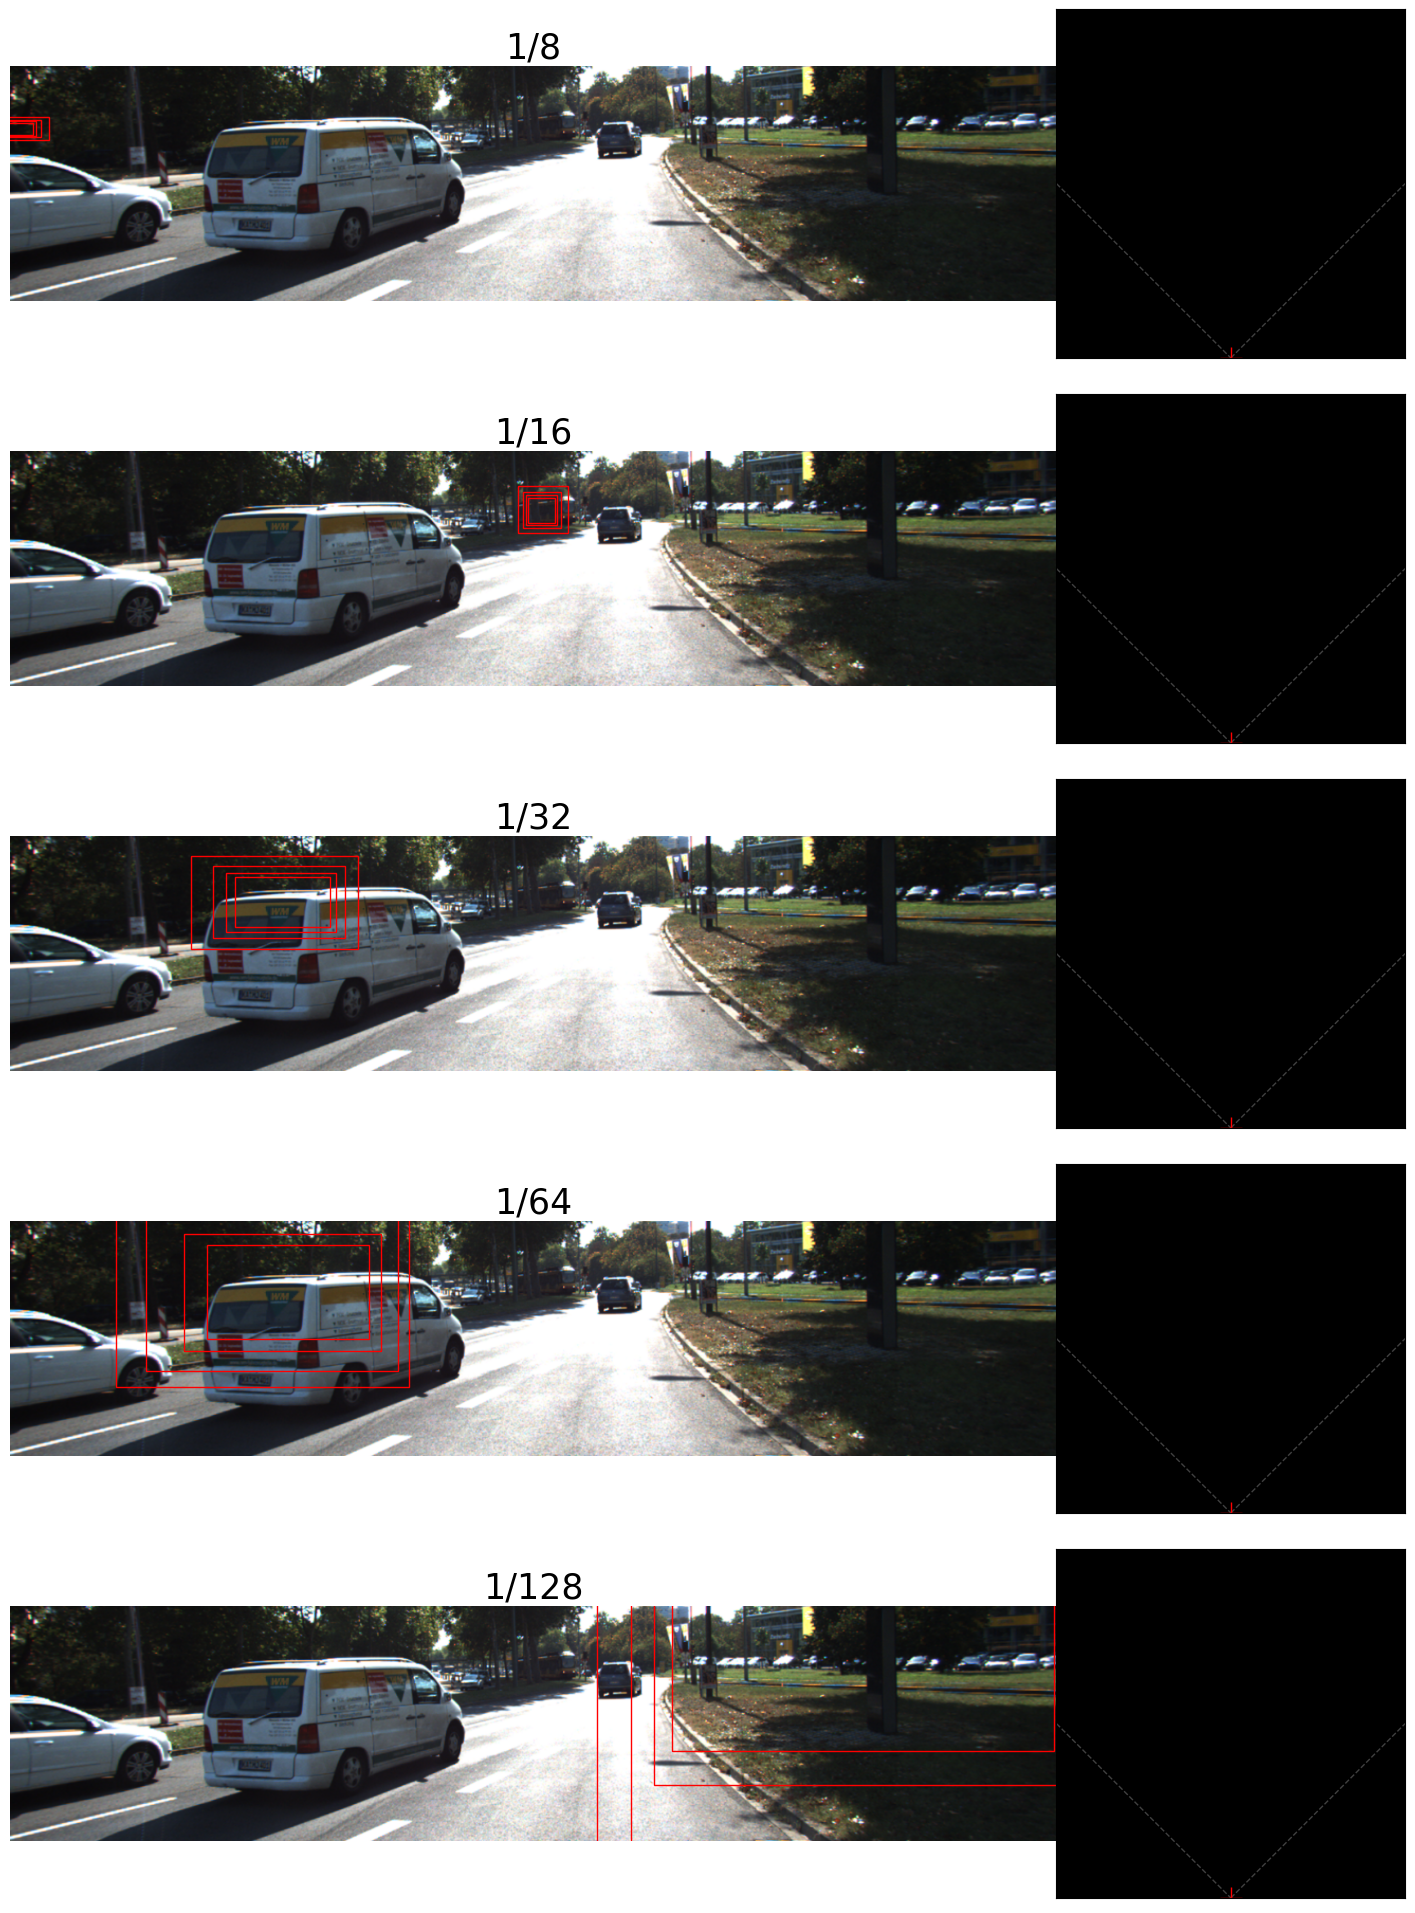

In [6]:
# %%script false --no-raise-error
# anchors_tensor.append([a.xmin, a.ymin, a.xmax, a.ymax, 0, 
#                         a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha,
#                         a.x3d, a.y3d, a.z3d, a.rot_y])
img = load_tf_image("/home/lab530/KenYu/kitti/training/image_2/000296.png") # 'A' type image


axs = init_img_plt([img]*5, titles = [f"1/{2**i}" for i in PYRIMID_LEVEL])

# cz_range = {3: list(range(0, 81, 1)),
#           4: list(range(0, 81, 1)),
#           5: list(range(0, 81, 1)),
#           6: list(range(0, 81, 1)),
#           7: list(range(0, 81, 1))}

# cz_range = {3: list(range(60, 81, 5)),
#           4: list(range(40, 70, 3)),
#           5: list(range(30, 40, 2)),
#           6: list(range(15, 30, 2)),
#           7: list(range(0,  15, 2))}

# cz_range = {3: list(range(58, 79, 4)), # [58, 78] -> [21, 22, 23, 24, 25]
#           4: list(range(38, 67, 3)), # [38, 66] -> [10, 11, 12, 13]
#           5: list(range(25, 38, 2)), # [25, 37] -> [5, 6]
#           6: list(range(10, 25, 2)), # [10, 37] -> [3]
#           7: list(range(3,  10, 1))} # [0, 16]   -> [1, 2]

# cz_range = {3: list(range(37, 54, 1)), # [37, 53] -> [6, 7, 8, 9, 10]
#             4: list(range(24, 44, 1)), # [24, 43] -> [3, 4, 5]
#             5: list(range(11, 46, 1)), # [11, 33] -> [2, 3]
#             6: list(range(10, 51, 1)), # [10, 50] -> [1]
#             7: list(range(3, 15, 1))}  # [0, 16]  -> [1]

# cz_range = {3: [40, 50, 60], # 3
#             4: [20, 23, 25, 30, 40], # 5 
#             5: [15, 17, 20, 23, 25, 30], # 6
#             6: [7,  9, 11, 13, 15, 17, 19], # 7
#             7: [3, 4, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14 ,15]} # 13

# cz_range = {3: list(range(42, 81, int((81-42)/3))),
#             4: list(range(22, 42, int((42-22)/3))),
#             5: list(range(12, 22, int((22-12)/3))),
#             6: list(range(7,  12, int((12-7)/3))),
#             7: list(range(3,  7,  int((7-3)/3)))}
cz_range = {3: [42, 55, 68, 80],
            4: [22, 28, 34, 40],
            5: [12, 15, 18, 21],
            6: [7,  8,  10, 12],
            7: [3,  4,   5,  6]}
# print(f"cz_range = {cz_range}")


# # For anchor_fpn
# y_f_idx_range = {3: [21, 22, 23, 24, 25],
#                  4: [10, 11, 12, 13],
#                  5: [5, 6, 7],
#                  6: [3, 4],
#                  7: [2]}

# GAC
y_f_idx_range = {3: list(range(36)),
                 4: list(range(18)),
                 5: list(range(9)),
                 6: list(range(5)),
                 7: list(range(3))}

# y_f_idx_range = {3: list(range(6, 15)),
#                  4: list(range(3, 9)),
#                  5: list(range(2, 6)),
#                  6: list(range(1, 4)),
#                  7: list(range(1, 2))}

# For GAC implement RetinaNet uneven stride
y_stride      = {3: 8,
                 4: 16,
                 5: 32,
                 6: 57,
                 7: 96}
# anchor_count for every pixel in different level 
# anchor_fpn:
    # anchor_count = 6 at level 3
    # anchor_count = 10 at level 4
    # anchor_count = 28 at level 5
    # anchor_count = 128 at level 6
    # anchor_count = 448 at level 7

# print(f"feats[0].shape = {feats[0].shape}") # torch.Size([8, 256, 36, 160]) 1/8
# print(f"feats[1].shape = {feats[1].shape}") # torch.Size([8, 256, 18, 80]) 1/16
# print(f"feats[2].shape = {feats[2].shape}") # torch.Size([8, 256, 9, 40]) 1/32
# print(f"feats[3].shape = {feats[3].shape}") # torch.Size([8, 256, 5, 20]) 1/64?
# print(f"feats[4].shape = {feats[4].shape}") # torch.Size([8, 256, 3, 10]) 1/128?

## Curve Fitting
def func(x, a, b, c, d, e ,f):
    return a*(x**5) + b*(x**4) + c*(x**3) + d*(x**2) + e*(x**1) + f
popt_upper = [-1.90815087e-09, 5.38463353e-07, -5.53958419e-05, 2.20737910e-03, 1.49866278e-04, 2.03962338e+00]
popt_lower = [ 1.90813996e-09,-5.38460756e-07,  5.53956217e-05,-2.20737124e-03,-1.49969144e-04, 1.40410610e+00]

anchors_dict = {3: [],
                4: [],
                5: [],
                6: [],
                7: []}

anchors_tensor = []

for pyrimid_level in PYRIMID_LEVEL:
    
    d_ratio = 2**pyrimid_level
    feat_map_h = int( INPUT_SHAPE[0] / d_ratio )
    feat_map_w = int( INPUT_SHAPE[1] / d_ratio )
    
    cx_offset_list = [4]
    cy_offset_list = [4]
    
    # Get Offset
    cx_offset_list = [int(d_ratio/2)]
    # cy_offset_list = [int(d_ratio/2)]
    cy_offset_list = [int(y_stride[pyrimid_level]/2)]
    
    # TODO, disable offset for now
    # if d_ratio == 8:
    #     cx_offset_list = [4]
    #     cy_offset_list = [4]
    # else:
    #     cx_offset_list = list(range(8, d_ratio, 16))
    #     cy_offset_list = list(range(8, d_ratio, 16))
    # # print(f"Level_{pyrimid_level} cx_offset_list = {cx_offset_list}")
    # # print(f"Level_{pyrimid_level} cy_offset_list = {cy_offset_list}")
    
    pass_dict = {}
    for cz in cz_range[pyrimid_level]:
        pass_dict[cz] = []
    
    anchor_count = 0
    
    sum_width = 0
    sum_height = 0
    for y_f_idx in y_f_idx_range[pyrimid_level]:
        for cy_offset in cy_offset_list:
            # cy = y_f_idx * d_ratio + cy_offset
            cy = y_f_idx * y_stride[pyrimid_level] + cy_offset
        
            for x_f_idx in range(feat_map_w):
                for cx_offset in cx_offset_list:
                    cx = x_f_idx * d_ratio + cx_offset

                    # print(f"(cx, cy) = {(cx, cy)}")
                    for cz in cz_range[pyrimid_level]:
                        
                        # Convert cx,cy,cz to x3d,y3d,z3d
                        loc_3d = np.linalg.inv(P2[:, :3]) @ np.array([[cx*cz], [cy*cz], [cz]])
                        loc_3d[1, 0] += AVG_HEIGT / 2.0 
                        
                        # Filter unreasonable y_3d 
                        # if not (func(cz, *popt_lower) < loc_3d[1, 0] < func(cz, *popt_upper)): continue
                        
                        if y_f_idx not in pass_dict[cz]: pass_dict[cz].append(y_f_idx)
                        
                        # TODO, for rot_y in [0, pi/2]:
                        rot_y = pi/2
                        str_line = f"Car NA NA NA NA NA NA NA {AVG_HEIGT} {AVG_WIDTH} {AVG_LENTH} {loc_3d[0, 0]} {loc_3d[1, 0]} {loc_3d[2, 0]} {rot_y} NA"
                        # a = KITTI_Object(str_line, is_transform = False, center_2d = (cx,cy,cz)) # TODO center_2d is problemetic
                        a = KITTI_Object(str_line, tf_matrix = P2)
                        # 
                        anchors_tensor.append(np.array([a.xmin, a.ymin, a.xmax, a.ymax, 0, a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha, a.x3d, a.y3d, a.z3d, a.rot_y]))

                        anchor_w = a.xmax - a.xmin
                        anchor_h = a.ymax - a.ymin
                        # print(f"(anchor_w, anchor_h) = {(anchor_w, anchor_h)}")
                        sum_width  += anchor_w
                        sum_height += anchor_h
                        
                        # anchors.append(a)
                        anchors_dict[pyrimid_level].append(a)
                        
                        anchor_count += 1
    print(f"anchor_count = {anchor_count} at level {pyrimid_level}")
    print(f"Average anchor width = {sum_width/anchor_count}")
    print(f"Average anchor height = {sum_height/anchor_count}")

    print(f"For pyrimid level_{pyrimid_level}")
    # print(pprint.pprint(pass_dict))

anchors_tensor = np.array(anchors_tensor)
anchors_tensor = torch.FloatTensor(anchors_tensor)
print(f"anchors_tensor.shape = {anchors_tensor.shape}") # [14284, 12]

# Draw anchors
for i_level, pyrimid_level in enumerate(PYRIMID_LEVEL):
    print(f"level_{i_level} has {len(anchors_dict[pyrimid_level])} anchors") # , and every pixel has {} anchors")
    sum_area = 0
    
    # # Draw ALL anchor 
    # for a in anchors_dict[pyrimid_level]:
    #     sum_area += a.area
    #     rnd_color = (random.random(), random.random(), random.random())
    #     # draw_corner_2D(axs[i_level][0], a.corner_2D, color = rnd_color, is_draw_front = False)
    #     draw_2Dbox    (axs[i_level][0], (a.xmin, a.ymin, a.xmax, a.ymax), color = rnd_color)
    #     draw_birdeyes (axs[i_level][1], a, color = rnd_color)
    
    # Draw a single anchor
    n_anchor_per_pixel = len(cz_range[pyrimid_level]) 
    start_smaple = int( len(anchors_dict[pyrimid_level])/(4*n_anchor_per_pixel) )*n_anchor_per_pixel
    for a_idx in range(start_smaple, start_smaple + n_anchor_per_pixel):
        a = anchors_dict[pyrimid_level][ a_idx ]
        draw_2Dbox    (axs[i_level][0], (a.xmin, a.ymin, a.xmax, a.ymax), color = (1,0,0))

        
    print(f"level_{i_level} has average area of {sum_area / len(anchors_dict[pyrimid_level])}")

print(f"Total Number of anchor = {anchors_tensor.shape[0]}")

# Show anchor on single pixel

level_0 has 23040 anchors
level_1 has 5760 anchors
level_2 has 1440 anchors
level_3 has 400 anchors
level_4 has 120 anchors


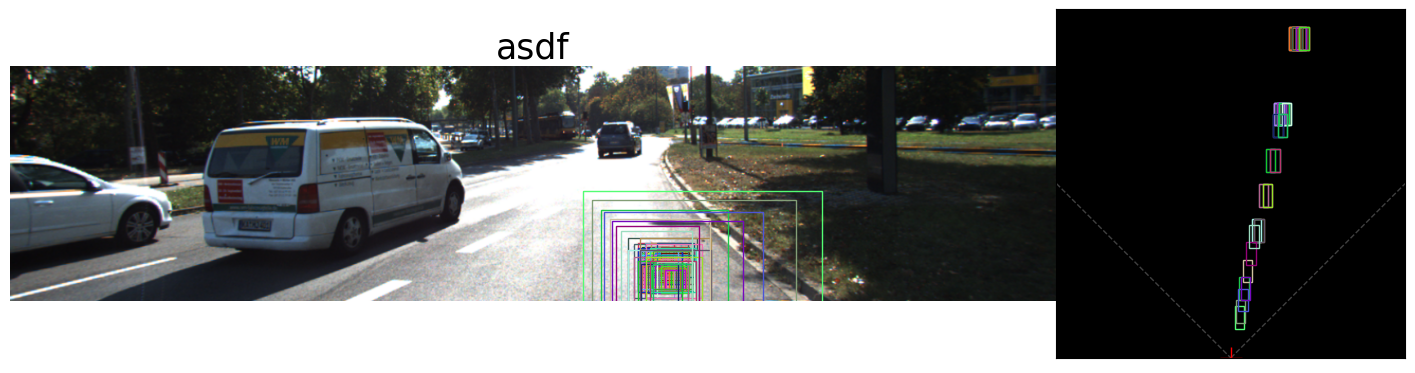

In [7]:
SHOW_COOR = (250, 800) # (384, 1280)
axs = init_img_plt([img], titles = ["asdf"])

for i_level, pyrimid_level in enumerate(PYRIMID_LEVEL):
    print(f"level_{i_level} has {len(anchors_dict[pyrimid_level])} anchors")
    for a in anchors_dict[pyrimid_level]:
        if abs(a.cx - SHOW_COOR[1]) < 16 and abs(a.cy - SHOW_COOR[0]) < 16:
            rnd_color = (random.random(), random.random(), random.random())

            draw_2Dbox    (axs[0][0], (a.xmin, a.ymin, a.xmax, a.ymax), color = rnd_color)
            draw_birdeyes (axs[0][1], a, color = rnd_color)


# Output anchor_fpn

In [8]:
# 3D Anchor
with open(f"pkl/{ANCHOR_NAME}.pkl", 'wb') as f:
    pickle.dump(anchors_tensor, f)
print(f"Write anchor result to {ANCHOR_NAME}.pkl")

# For 2D detector
with open(f"pkl/{ANCHOR_NAME}_2D.pkl", 'wb') as f:
    pickle.dump(anchors_tensor[:, :4], f)
    # print(anchors_tensor[:, :4].shape) # torch.Size([20960, 4])
print(f"Write anchor result to {ANCHOR_NAME}_2D.pkl")

# Get anchor_map
anchor_map = torch.ones((anchors_tensor.shape[0]), dtype=torch.bool)
print( f"Total number of anchor = {anchor_map.shape}" ) # torch.Size([30760])
with open(f"pkl/{ANCHOR_NAME}_map.pkl", 'wb') as f:
    pickle.dump(anchor_map, f)
print(f"Write anchor result to {ANCHOR_NAME}_map.pkl")

Write anchor result to anchors_gac_fpn_share_weight.pkl
Write anchor result to anchors_gac_fpn_share_weight_2D.pkl
Total number of anchor = torch.Size([30760])
Write anchor result to anchors_gac_fpn_share_weight_map.pkl
